In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from statsmodels.tsa.stattools import adfuller as adf
# import the custom functions from NN_support.py
from NN_support import RNN_sw_preprocess, RNN_model

In [ ]:
# load the data from the csv file and use the date as the index
data = pd.read_csv('InvestmentReplica.csv', header=0)
data = data.set_index('Date')
data.index = pd.to_datetime(data.index, dayfirst=True)
# divide it into indexes and futures
futures_list = ['RX1','TY1','GC1','CO1','ES1','VG1',
    'NQ1','LLL1','TP1','DU1', 'TU2' ]
indexes_list = ['MXWO','MXWD','LEGATRUU','HFRXGL']
indexes = data[indexes_list]
futures = data[futures_list]

# Data exploration
## Indexes data exploration

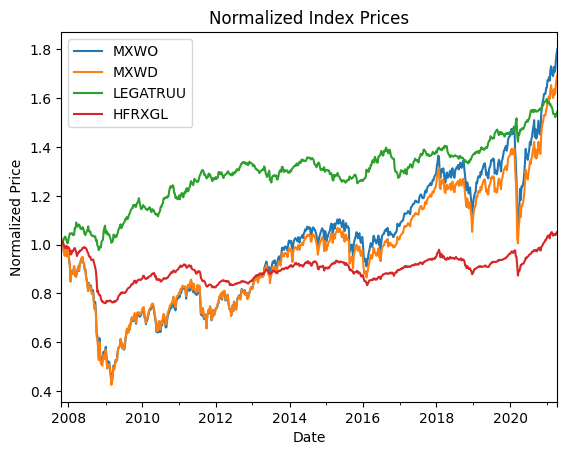

In [3]:
# plot the indexes
indexes_norm = indexes.div(indexes.iloc[0])
indexes_plot = indexes_norm.plot()
indexes_plot.set_ylabel('Normalized Price')
indexes_plot.set_xlabel('Date')
indexes_plot.set_title('Normalized Index Prices')
plt.show()

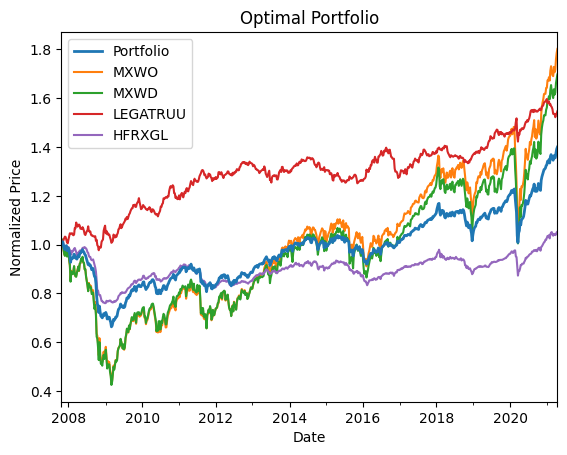

Optimal Weights:
[ 0.51298836 -0.5711139   0.43728726  0.62083829]
Expected Return:
0.0005389851958403927
Standard Deviation:
0.01099364337454438


In [4]:
# define the expected returns, their covariance matrix and the fixed return
# we want to achieve
returns = indexes.pct_change().dropna()
mu = returns.mean()
Sigma = returns.cov()
Sigma_inv = np.linalg.inv(Sigma)
r = 0.3
ones = np.ones(len(mu))

# calculate the optimal weights
w = Sigma_inv.dot(mu-r*ones)/(ones.T.dot(Sigma_inv).dot(mu-r*ones))

# define the portfolio through the optimal weights
portfolio = indexes.dot(w)
portfolio.name = 'Portfolio'

portfolio_norm = portfolio.div(portfolio.iloc[0])
portfolio_plot = portfolio_norm.plot(zorder=1, lw=2)
indexes_norm.plot(ax=portfolio_plot, zorder=0)
portfolio_plot.set_ylabel('Normalized Price')
portfolio_plot.set_xlabel('Date')
portfolio_plot.set_title('Optimal Portfolio')
portfolio_plot.legend(loc='best')
plt.show()

# print the optimal weights and the expected return
print('Optimal Weights:')
print(w)
print('Expected Return:')
print(portfolio.pct_change().mean())
print('Standard Deviation:')
print(portfolio.pct_change().std())

## Futures data exploration

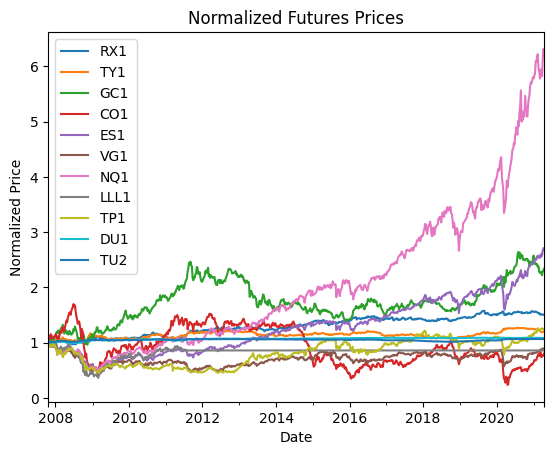

In [5]:
# graph the futures normalized prices
futures_norm = futures.div(futures.iloc[0])
futures_plot = futures_norm.plot()
futures_plot.set_ylabel('Normalized Price')
futures_plot.set_xlabel('Date')
futures_plot.set_title('Normalized Futures Prices')
plt.show()

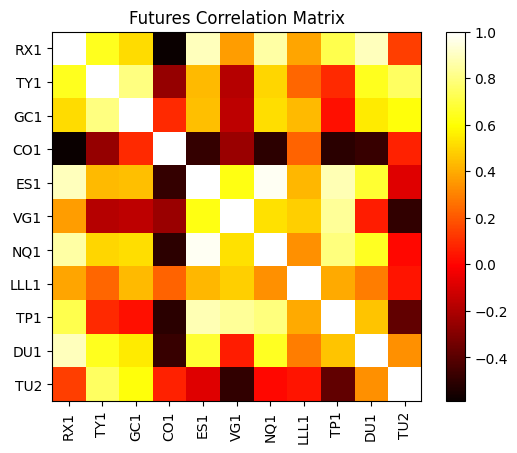

In [6]:
# create the correlation matrix heatmap
futures_corr = futures_norm.corr()
futures_corr_plot = plt.imshow(futures_corr, cmap='hot',
    interpolation='nearest')
plt.colorbar()
plt.xticks(range(len(futures_corr)), futures_corr.columns, rotation=90)
plt.yticks(range(len(futures_corr)), futures_corr.columns)
plt.title('Futures Correlation Matrix')
plt.show()

# Stationarity test
## Original target data

In [7]:
# perform the adf test on the target data
adf_result = adf(portfolio)
print(f""" -- ADF Test --
ADF Statistic: {adf_result[0]}
p-value: {adf_result[1]}
Critical Values:
    1%: {adf_result[4]['1%']}
    5%: {adf_result[4]['5%']}
    10%: {adf_result[4]['10%']}
{ ' The time series is Stationary' if adf_result[0] < adf_result[4]['5%']
    else 'The time series is not Stationary'}
(with 95% confidence)
""")

 -- ADF Test --
ADF Statistic: 0.6445228965397661
p-value: 0.9886631474209259
Critical Values:
    1%: -3.4396861854831964
    5%: -2.865660062273053
    10%: -2.5689640195342456
The time series is not Stationary
(with 95% confidence)



## First differences of the target

In [8]:
# get the returns of the portfolio
portfolio_diff = portfolio.diff().dropna()

# perform the adf test on the returns of the portfolio
adf_result = adf(portfolio_diff)
print(f""" -- ADF Test --
ADF Statistic: {adf_result[0]}
p-value: {adf_result[1]}
Critical Values:
    1%: {adf_result[4]['1%']}
    5%: {adf_result[4]['5%']}
    10%: {adf_result[4]['10%']}
{ ' The time series is Stationary' if adf_result[0] < adf_result[4]['5%']
    else 'The time series is not Stationary'}
(with 95% confidence)
""")

 -- ADF Test --
ADF Statistic: -22.339688012330694
p-value: 0.0
Critical Values:
    1%: -3.4396861854831964
    5%: -2.865660062273053
    10%: -2.5689640195342456
 The time series is Stationary
(with 95% confidence)



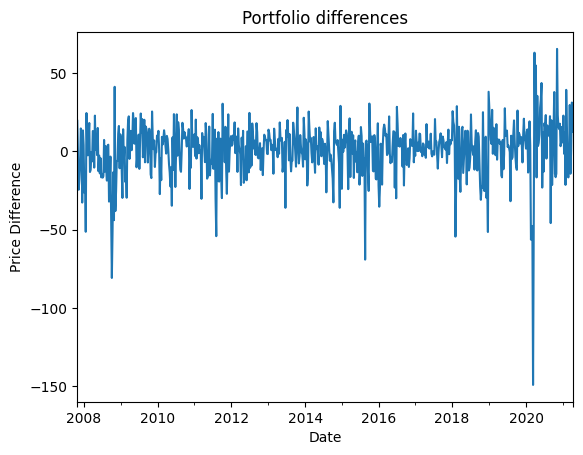

In [9]:
# graph the portfolio differences
portfolio_diff_plot = portfolio_diff.plot()
portfolio_diff_plot.set_ylabel('Price Difference')
portfolio_diff_plot.set_xlabel('Date')
portfolio_diff_plot.set_title('Portfolio differences')
plt.show()

## Original futures data

In [10]:
# perform the adf test on the futures data
for future in futures:
    adf_result = adf(futures[future])
    print(
        f"{future:>4} -- {adf_result[0]:>5.2f}, {adf_result[1]:.2f} -- " \
        f"""{
            'Stationary' if adf_result[0] < adf_result[4]['5%']
            else 'Not Stationary'
        }"""
    )

 RX1 -- -1.26, 0.65 -- Not Stationary
 TY1 -- -2.66, 0.08 -- Not Stationary
 GC1 -- -1.60, 0.48 -- Not Stationary
 CO1 -- -2.47, 0.12 -- Not Stationary
 ES1 --  2.06, 1.00 -- Not Stationary
 VG1 -- -2.95, 0.04 -- Stationary
 NQ1 --  3.66, 1.00 -- Not Stationary
LLL1 -- -3.40, 0.01 -- Stationary
 TP1 -- -0.99, 0.76 -- Not Stationary
 DU1 -- -2.28, 0.18 -- Not Stationary
 TU2 -- -1.94, 0.32 -- Not Stationary


## First differences of the futures

In [11]:
# get the returns of the futures
futures_diff = futures.diff().dropna()

# perform the adf test on the returns of the futures
for future in futures_diff:
    adf_result = adf(futures_diff[future])
    print(
        f"{future:>4} -- {adf_result[0]:>6.2f}, {adf_result[1]:.2f} -- " \
        f"""{
            'Stationary' if adf_result[0] < adf_result[4]['5%']
            else 'Not Stationary'
        }"""
    )

 RX1 -- -20.99, 0.00 -- Stationary
 TY1 -- -27.35, 0.00 -- Stationary
 GC1 -- -29.09, 0.00 -- Stationary
 CO1 --  -8.52, 0.00 -- Stationary
 ES1 --  -8.98, 0.00 -- Stationary
 VG1 -- -15.18, 0.00 -- Stationary
 NQ1 --  -8.70, 0.00 -- Stationary
LLL1 --  -4.50, 0.00 -- Stationary
 TP1 -- -28.15, 0.00 -- Stationary
 DU1 --  -6.58, 0.00 -- Stationary
 TU2 --  -6.55, 0.00 -- Stationary


# Neural network models
We will test a few different types of neural networks to see which one performs
best.  
The data we feed the neural network will be the first differences of the target
and futures data, since they are stationary.
## Data preparation

In [12]:
# normalize, reshape and split the data
lookback = 30
train_size = 0.8
X_train, y_train, X_test, y_test = \
    RNN_sw_preprocess(futures_diff, portfolio_diff, lookback, train_size)

## Recurrent neural network
### Creating the model

In [13]:
# define the model
model = RNN_model(lookback, futures_list)

# summary of the model
model.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 30, 11)]     0           []                               
                                                                                                  
 simple_rnn (SimpleRNN)         (None, 32)           1408        ['input_1[0][0]']                
                                                                                                  
 input_2 (InputLayer)           [(None, 1)]          0           []                               
                                                                                                  
 dense (Dense)                  (None, 11)           363         ['simple_rnn[0][0]']             
                                                                                              

In [14]:
# compile the model with the custom loss function
model.compile(loss=None, optimizer='adam')

# train the model with cross validation
history = model.fit(x=[X_train, y_train], y=None, epochs=100, batch_size=32,
    verbose=1, validation_split=0.2)

Epoch 1/100
14/14 [==============================] - 1s 18ms/step - loss: 29.3076 - val_loss: 2.8062
Epoch 2/100
14/14 [==============================] - 0s 6ms/step - loss: 15.5411 - val_loss: 2.3469
Epoch 3/100
14/14 [==============================] - 0s 5ms/step - loss: 9.8976 - val_loss: 2.1091
Epoch 4/100
14/14 [==============================] - 0s 5ms/step - loss: 6.9976 - val_loss: 1.8332
Epoch 5/100
14/14 [==============================] - 0s 5ms/step - loss: 5.0640 - val_loss: 1.6011
Epoch 6/100
14/14 [==============================] - 0s 5ms/step - loss: 4.0517 - val_loss: 1.4080
Epoch 7/100
14/14 [==============================] - 0s 5ms/step - loss: 3.4419 - val_loss: 1.2415
Epoch 8/100
14/14 [==============================] - 0s 5ms/step - loss: 2.7965 - val_loss: 1.1208
Epoch 9/100
14/14 [==============================] - 0s 5ms/step - loss: 2.4398 - val_loss: 1.0162
Epoch 10/100
14/14 [==============================] - 0s 5ms/step - loss: 2.1259 - val_loss: 0.9461
Epoch 

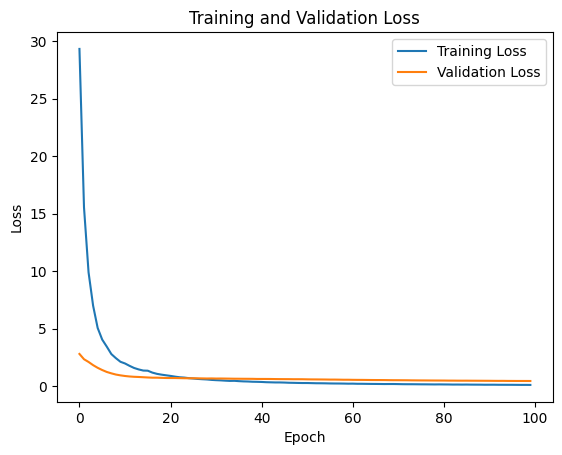

In [17]:
# plot the training and validation loss
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Training and Validation Loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Training Loss', 'Validation Loss'], loc='best')
plt.show()